In [1]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import gensim
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import imblearn

### Loading text file

In [2]:
train_raw = open("../dataset/training_text", "r").readlines()[1:]
test_raw = open("../dataset/test_text_2", "r").readlines()

In [3]:
# Removing uppercase letters, || and -

train_lower = [line.lower().replace("||", " ").replace("-", " ") for line in train_raw]
test_lower = [line.lower().replace("||", " ").replace("-", " ") for line in test_raw]

### Tokenizing

In [4]:
train_token = [word_tokenize(line) for line in train_lower]
test_token = [word_tokenize(line) for line in test_lower]

train_token[0][0:10]

['0',
 'cyclin',
 'dependent',
 'kinases',
 '(',
 'cdks',
 ')',
 'regulate',
 'a',
 'variety']

In [5]:
test_token[0][0:10]

['12',
 'tet',
 'proteins',
 'oxidize',
 '5',
 'methylcytosine',
 '(',
 '5mc',
 ')',
 'on']

### Removing Stopwords and punctuation

In [6]:
english_stops = set(stopwords.words('english'))

In [7]:
train_stopwords = [[word for word in train_token[i] if word not in english_stops and word.isalpha()] for 
                   i in range(len(train_token))]
test_stopwords = [[word for word in test_token[i] if word not in english_stops and word.isalpha()] for 
                   i in range(len(test_token))]
train_stopwords[0][0:10]

['cyclin',
 'dependent',
 'kinases',
 'cdks',
 'regulate',
 'variety',
 'fundamental',
 'cellular',
 'processes',
 'stands']

In [8]:
test_stopwords[0][0:10]

['tet',
 'proteins',
 'oxidize',
 'methylcytosine',
 'dna',
 'play',
 'important',
 'roles',
 'various',
 'biological']

### Lemmatization

In [9]:
train_lemma = [[WordNetLemmatizer().lemmatize(word) for word in train_stopwords[i]] for 
               i in range(len(train_stopwords))]
test_lemma = [[WordNetLemmatizer().lemmatize(word) for word in test_stopwords[i]] for 
               i in range(len(test_stopwords))]
train_lemma[0][0:10]

['cyclin',
 'dependent',
 'kinase',
 'cdks',
 'regulate',
 'variety',
 'fundamental',
 'cellular',
 'process',
 'stand']

In [10]:
test_lemma[0][0:10]

['tet',
 'protein',
 'oxidize',
 'methylcytosine',
 'dna',
 'play',
 'important',
 'role',
 'various',
 'biological']

### Doc2Vec

In [11]:
train_corpus = [gensim.models.doc2vec.TaggedDocument(train_lemma[i], [i]) for i in range(len((train_lemma)))]
test_corpus = test_lemma
train_corpus[:2]

[TaggedDocument(words=['cyclin', 'dependent', 'kinase', 'cdks', 'regulate', 'variety', 'fundamental', 'cellular', 'process', 'stand', 'one', 'last', 'orphan', 'cdks', 'activating', 'cyclin', 'identified', 'kinase', 'activity', 'revealed', 'previous', 'work', 'shown', 'silencing', 'increase', 'v', 'ets', 'erythroblastosis', 'virus', 'oncogene', 'homolog', 'driven', 'activation', 'mapk', 'pathway', 'confers', 'tamoxifen', 'resistance', 'breast', 'cancer', 'cell', 'precise', 'mechanism', 'modulates', 'activity', 'generally', 'function', 'remain', 'elusive', 'demonstrate', 'cyclin', 'dependent', 'kinase', 'identifying', 'cyclin', 'activating', 'cyclin', 'cyclin', 'orphan', 'cyclin', 'product', 'whose', 'mutation', 'cause', 'star', 'syndrome', 'human', 'developmental', 'anomaly', 'whose', 'feature', 'include', 'toe', 'syndactyly', 'telecanthus', 'anogenital', 'renal', 'malformation', 'show', 'star', 'syndrome', 'associated', 'cyclin', 'mutant', 'unable', 'interact', 'cyclin', 'silencing', '

In [12]:
test_corpus[:2]

[['tet',
  'protein',
  'oxidize',
  'methylcytosine',
  'dna',
  'play',
  'important',
  'role',
  'various',
  'biological',
  'process',
  'mutation',
  'frequently',
  'observed',
  'myeloid',
  'malignance',
  'present',
  'crystal',
  'structure',
  'human',
  'bound',
  'methylated',
  'dna',
  'å',
  'resolution',
  'structure',
  'show',
  'two',
  'zinc',
  'finger',
  'bring',
  'cys',
  'rich',
  'dsbh',
  'domain',
  'together',
  'form',
  'compact',
  'catalytic',
  'domain',
  'cys',
  'rich',
  'domain',
  'stabilizes',
  'dna',
  'dsbh',
  'core',
  'specifically',
  'recognizes',
  'cpg',
  'dinucleotide',
  'show',
  'substrate',
  'preference',
  'cpg',
  'context',
  'inserted',
  'catalytic',
  'cavity',
  'methyl',
  'group',
  'orientated',
  'catalytic',
  'fe',
  'ii',
  'reaction',
  'methyl',
  'group',
  'involved',
  'dna',
  'contact',
  'catalytic',
  'cavity',
  'allows',
  'accommodate',
  'derivative',
  'oxidation',
  'mutation',
  'fe',
  'ii',
  

In [13]:
model = gensim.models.doc2vec.Doc2Vec(train_corpus, vector_size=50)

In [14]:
X_test = pd.DataFrame([model.infer_vector(line) for line in test_corpus])

In [15]:
train_labels = pd.read_csv("../dataset/training_variants")["Class"]
train = pd.DataFrame([model.docvecs[i] for i in range(len(train_corpus))])
train["Class"] = train_labels
X_train = train[[c for c in train.columns if c != "Class"]]
Y_train = train["Class"]
Y_test = pd.read_csv("../dataset/test_variants_2")["class"]

### Applying PCA to vizualize results

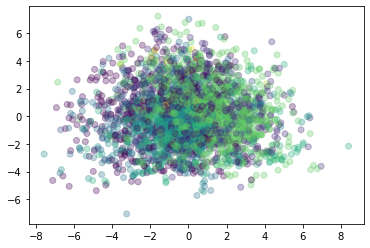

In [16]:
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)
fig, ax = plt.subplots()
ax.scatter(X_train_reduced[:,0], X_train_reduced[:,1], c=Y_train, label=Y_train, alpha=0.3)
plt.show()

### Training model

In [17]:
SVM_model = svm.SVC(probability = True).fit(X_train, Y_train)

In [18]:
SVM_model.score(X_train, Y_train)

0.695874736525143

In [19]:
prob = SVM_model.predict_proba(X_test)
predict = SVM_model.predict(X_test)

In [20]:
print("Log Loss: " + str(log_loss(Y_test, prob)))
print("Accuracy: " + str(accuracy_score(Y_test, predict)))
print("\nConfusion Matrix: ")
pd.DataFrame(confusion_matrix(Y_test, predict))

Log Loss: 1.0723669141144243
Accuracy: 0.6195652173913043

Confusion Matrix: 


,0,1,2,3,4,5,6,7,8
0,67,2,0,14,0,0,11,0,0
1,4,9,0,2,0,0,31,0,0
2,2,0,0,1,0,0,4,0,0
3,21,1,0,34,0,0,9,0,0
4,7,0,0,6,8,0,4,0,0
5,3,0,1,2,0,10,6,0,0
6,2,1,1,0,0,0,97,0,0
7,0,1,0,0,0,0,1,0,0
8,2,0,0,1,0,0,0,0,3


### Trying different vector sizes

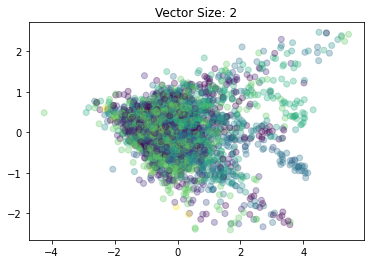

Log Loss: 1.8054226902679849
Accuracy: 0.26902173913043476

Confusion Matrix: 
   0  1  2  3  4  5   6  7  8
0  0  0  0  0  0  0  94  0  0
1  0  0  0  1  0  0  45  0  0
2  0  0  0  0  0  0   7  0  0
3  0  0  0  0  0  0  65  0  0
4  0  0  0  0  0  0  25  0  0
5  0  0  0  0  0  0  22  0  0
6  0  0  0  2  0  0  99  0  0
7  0  0  0  0  0  0   2  0  0
8  0  0  0  0  0  0   6  0  0


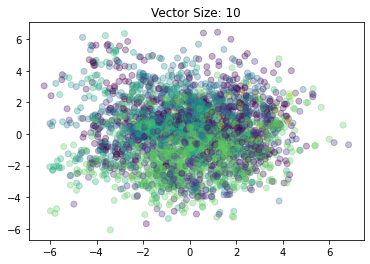

Log Loss: 1.2859907071993673
Accuracy: 0.5217391304347826

Confusion Matrix: 
    0  1  2   3  4  5   6  7  8
0  51  2  0  16  3  0  22  0  0
1   5  5  0   1  0  0  35  0  0
2   1  0  0   2  0  0   4  0  0
3  19  1  0  30  0  0  15  0  0
4   9  1  0   5  6  0   4  0  0
5   4  0  0   2  5  5   6  0  0
6   2  1  0   2  1  0  95  0  0
7   0  0  0   0  0  0   2  0  0
8   5  0  0   1  0  0   0  0  0


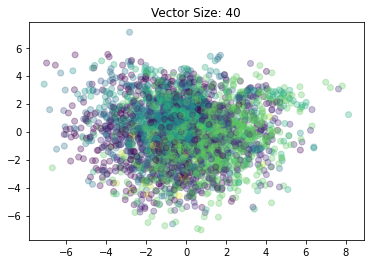

Log Loss: 1.0841996337992197
Accuracy: 0.6141304347826086

Confusion Matrix: 
    0   1  2   3  4  5   6  7  8
0  67   1  0  15  0  0  11  0  0
1   2  11  0   2  0  0  31  0  0
2   2   0  0   1  0  0   4  0  0
3  19   1  0  32  0  0  13  0  0
4  10   0  0   5  5  0   5  0  0
5   4   0  1   1  1  9   6  0  0
6   0   2  0   1  0  0  98  0  0
7   1   0  0   0  0  0   1  0  0
8   1   0  0   1  0  0   0  0  4


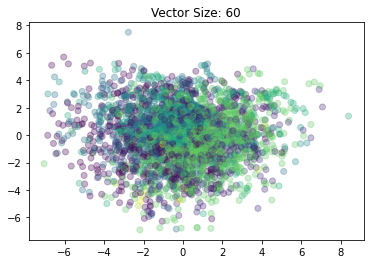

Log Loss: 1.044152725824343
Accuracy: 0.6222826086956522

Confusion Matrix: 
    0   1  2   3   4   5   6  7  8
0  71   2  0  10   0   0  11  0  0
1   4  11  0   2   0   0  29  0  0
2   2   0  0   1   0   0   4  0  0
3  30   0  0  29   0   0   6  0  0
4   7   1  0   3  10   0   4  0  0
5   6   1  1   1   0  10   3  0  0
6   1   4  1   1   0   0  94  0  0
7   1   0  0   0   0   0   1  0  0
8   1   0  0   1   0   0   0  0  4


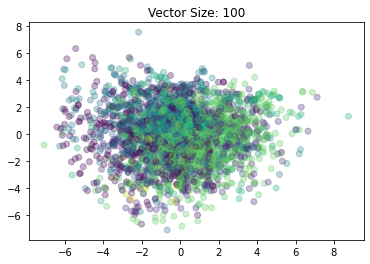

Log Loss: 1.0748085171080453
Accuracy: 0.6114130434782609

Confusion Matrix: 
    0   1  2   3  4   5   6  7  8
0  68   0  0  14  0   0  12  0  0
1   4  14  0   0  0   1  27  0  0
2   2   0  0   1  0   0   4  0  0
3  20   0  0  36  0   0   9  0  0
4  15   1  0   5  0   0   4  0  0
5   5   2  1   0  0  10   4  0  0
6   1   5  1   0  0   0  94  0  0
7   0   1  0   0  0   0   1  0  0
8   2   0  0   1  0   0   0  0  3


In [22]:
sizes = [2, 10, 40, 60, 100]

for size in sizes:
    
    # Doc2Vec
    model = gensim.models.doc2vec.Doc2Vec(train_corpus, vector_size = size)
    X_test = pd.DataFrame([model.infer_vector(line) for line in test_corpus])
    X_train = pd.DataFrame([model.docvecs[i] for i in range(len(train_corpus))])
    
    # Applying PCA
    pca = PCA(n_components=2)
    X_train_reduced = pca.fit_transform(X_train)
    fig, ax = plt.subplots()
    ax.set_title('Vector Size: ' + str(size))
    ax.scatter(X_train_reduced[:,0], X_train_reduced[:,1], c=Y_train, label=Y_train, alpha=0.3)
    plt.show()

    # SVC
    SVM_model = svm.SVC(probability = True).fit(X_train, Y_train)
    prob = SVM_model.predict_proba(X_test)
    predict = SVM_model.predict(X_test)
    print("Log Loss: " + str(log_loss(Y_test, prob)))
    print("Accuracy: " + str(accuracy_score(Y_test, predict)))
    print("\nConfusion Matrix: ")
    print(pd.DataFrame(confusion_matrix(Y_test, predict)))

### Balancing Training data with SMOTE

In [23]:
oversample = imblearn.over_sampling.SMOTE()

size = 60
    
# Doc2Vec
model = gensim.models.doc2vec.Doc2Vec(train_corpus, vector_size = size)
X_test = pd.DataFrame([model.infer_vector(line) for line in test_corpus])
X_train = pd.DataFrame([model.docvecs[i] for i in range(len(train_corpus))])
X_train_over, Y_train_over = oversample.fit_resample(X_train, Y_train)

# SVC
SVM_model = svm.SVC(probability = True).fit(X_train_over, Y_train_over)
prob = SVM_model.predict_proba(X_test)
predict = SVM_model.predict(X_test)
print("Log Loss: " + str(log_loss(Y_test, prob)))
print("Accuracy: " + str(accuracy_score(Y_test, predict)))
print("\nConfusion Matrix: ")
print(pd.DataFrame(confusion_matrix(Y_test, predict)))

Log Loss: 1.076539672689965
Accuracy: 0.5978260869565217

Confusion Matrix: 
    0   1  2   3   4   5   6  7  8
0  63   4  0   9   7   2   9  0  0
1   5  15  0   0   1   2  23  0  0
2   2   0  2   1   0   0   2  0  0
3  21   3  0  27   1   1  12  0  0
4   5   1  0   1  13   0   5  0  0
5   3   2  1   1   0  13   2  0  0
6   1  10  4   1   2   0  83  0  0
7   1   1  0   0   0   0   0  0  0
8   2   0  0   0   0   0   0  0  4


### Trying different models

In [32]:
# XGBoost
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators = 80, learning_rate = 0.1, max_depth = 5).fit(X_train, Y_train)
predict = model.predict(X_test)
prob = SVM_model.predict_proba(X_test)
print("Log Loss: " + str(log_loss(Y_test, prob)))
print("Accuracy: " + str(accuracy_score(Y_test, predict)))
print("\nConfusion Matrix: ")
print(pd.DataFrame(confusion_matrix(Y_test, predict)))

Log Loss: 1.076539672689965
Accuracy: 0.5760869565217391

Confusion Matrix: 
    0   1  2   3  4  5   6  7  8
0  53   0  0  21  3  2  15  0  0
1   2  12  0   3  0  0  29  0  0
2   2   0  0   1  0  0   4  0  0
3  13   0  0  42  1  0   9  0  0
4  11   1  0  10  0  0   3  0  0
5   6   0  1   2  0  8   5  0  0
6   3   4  1   0  0  0  93  0  0
7   0   2  0   0  0  0   0  0  0
8   0   0  0   1  0  0   1  0  4


In [40]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=80, n_estimators = 100).fit(X_train, Y_train)
predict = model.predict(X_test)
prob = SVM_model.predict_proba(X_test)
print("Log Loss: " + str(log_loss(Y_test, prob)))
print("Accuracy: " + str(accuracy_score(Y_test, predict)))
print("\nConfusion Matrix: ")
print(pd.DataFrame(confusion_matrix(Y_test, predict)))

Log Loss: 1.076539672689965
Accuracy: 0.5489130434782609

Confusion Matrix: 
    0  1  2   3  4  5   6  7  8
0  59  0  0  19  1  1  14  0  0
1   4  6  0   1  0  0  35  0  0
2   2  0  0   1  0  0   4  0  0
3  13  1  0  40  0  0  11  0  0
4  11  2  0   9  0  0   3  0  0
5   6  0  0   4  1  6   5  0  0
6   2  8  0   2  1  0  88  0  0
7   1  0  0   0  0  0   1  0  0
8   2  0  0   0  0  0   1  0  3
